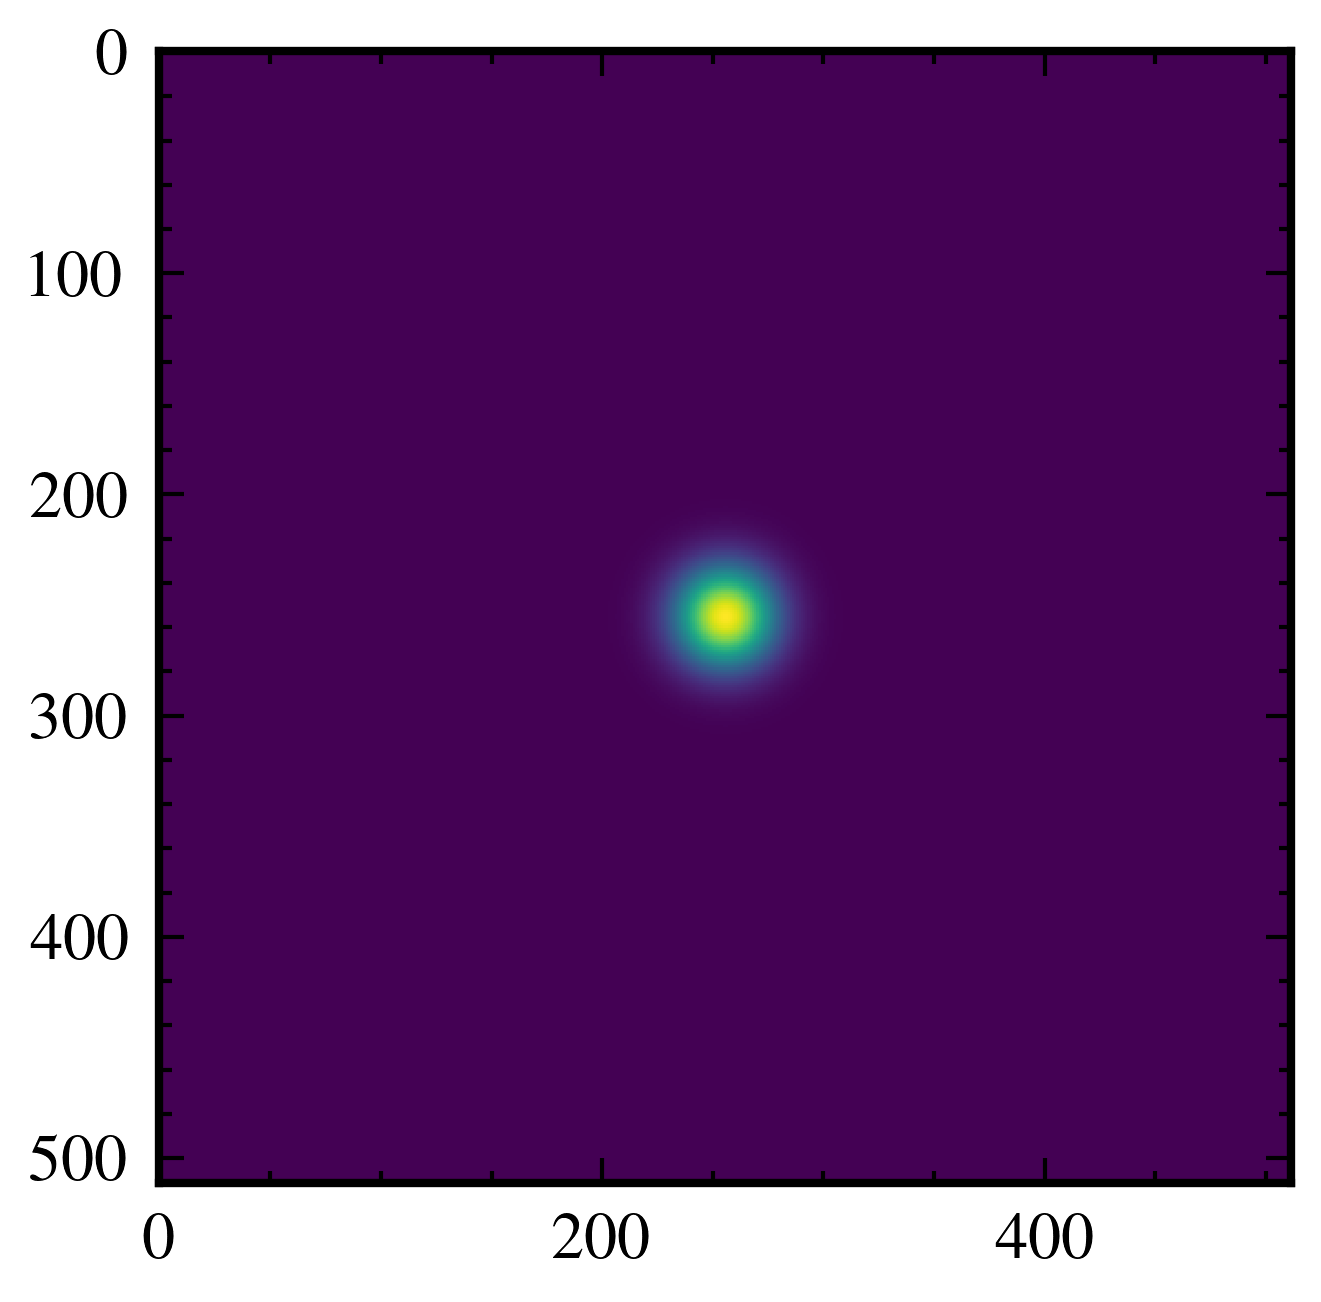

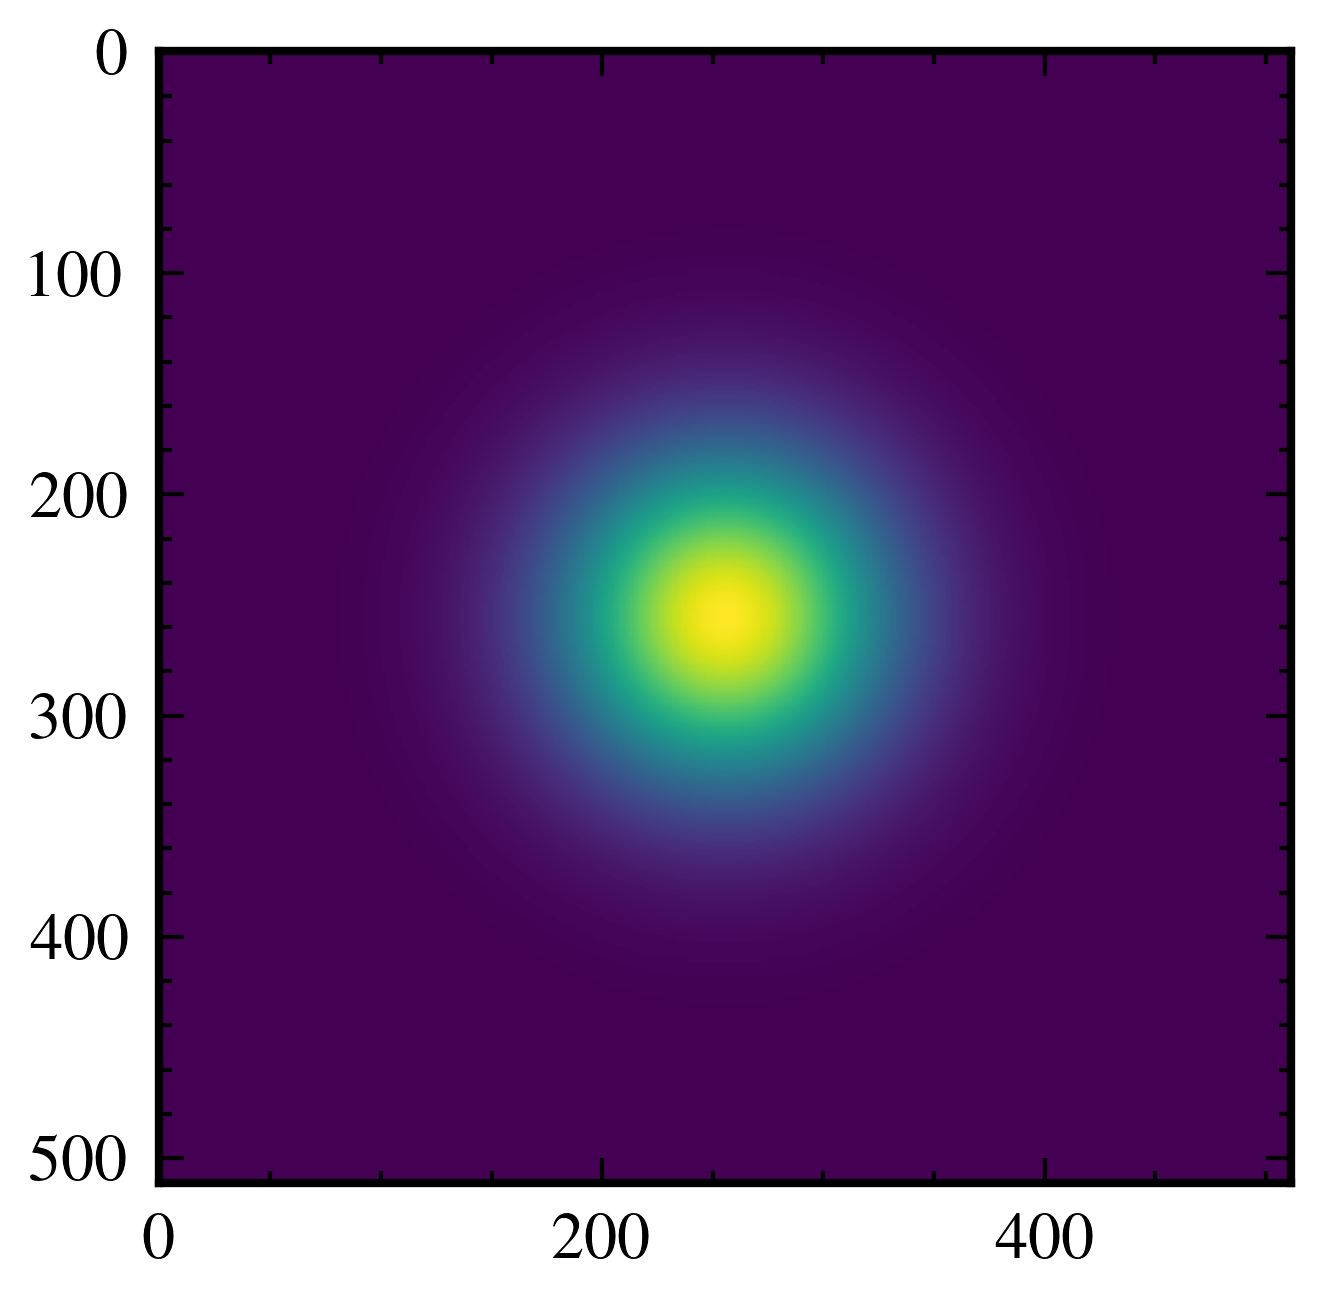

In [3]:
from matplotlib import pyplot as plt

mesh = Mesh(nx = 512, ny = 512, xMin = -300e-06, xMax = 300e-06, yMin= -300e-06, yMax= 300e-06)
src_GM = SA1_Source(ekev = 5.0, q = 0.25, S = 1, mesh = mesh)
plt.imshow(src_GM.wfr.get_intensity().sum(-1))
plt.show()

plt.imshow(gaussian_filter(src_GM.wfr.get_intensity().sum(-1), sigma = 50, mode = 'constant', cval = 0))
    

In [7]:
import os

from wpg.wpg_uti_wf import plot_intensity_map

from felpy.model.tools import scale
from felpy.model.wavefront import Wavefront
from felpy.model.beamlines.exfel_spb.methods import setup_spb
from felpy.analysis.dataset import Dataset

from labwork.about import dCache

from felpy.model.beamline import Beamline

from wpg.optical_elements import Drift
from felpy.model.tools import propagation_parameters

from felpy.model.source import SA1_Source, Source_WPG, Source
from felpy.model.mesh import Mesh

from felpy.analysis.statistics.correlation import norm
from scipy.ndimage import gaussian_filter

Initialising Single Particle Beamline
None
d1


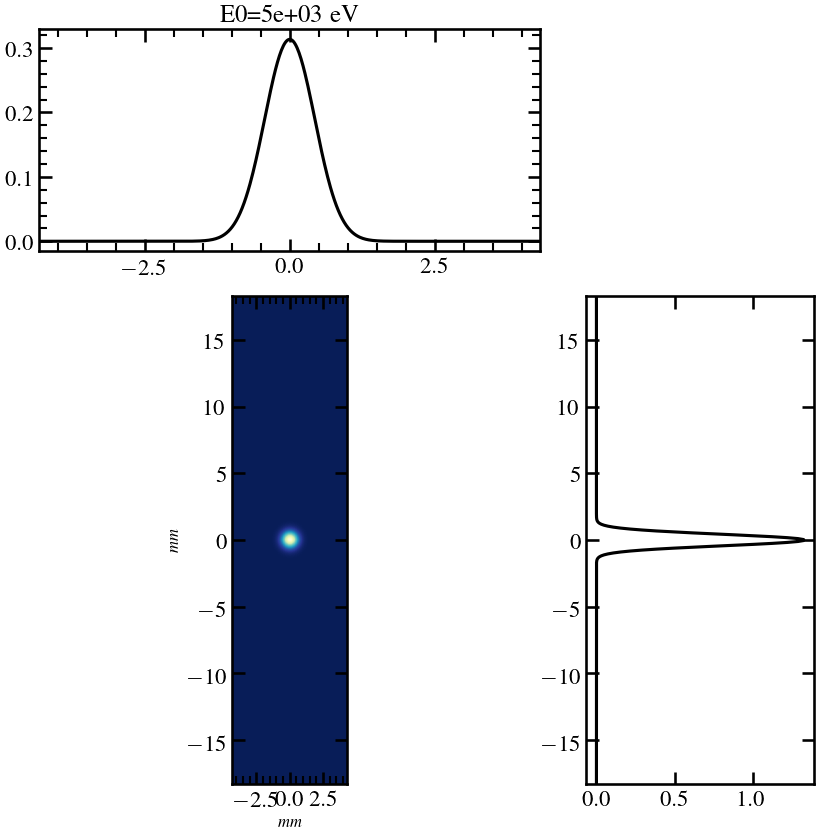

HOM1


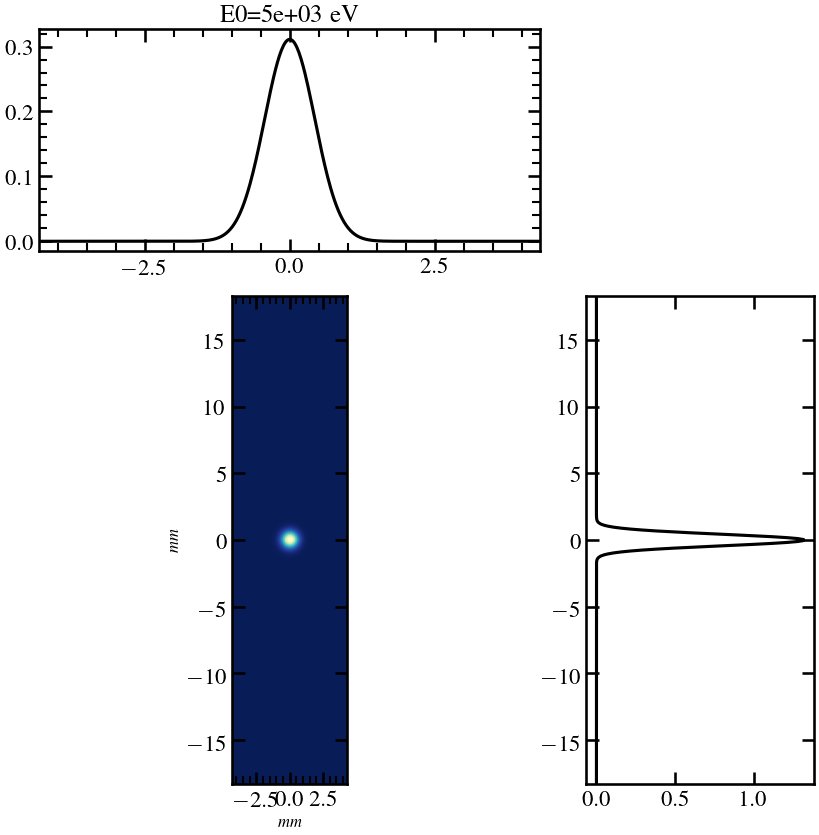

d2


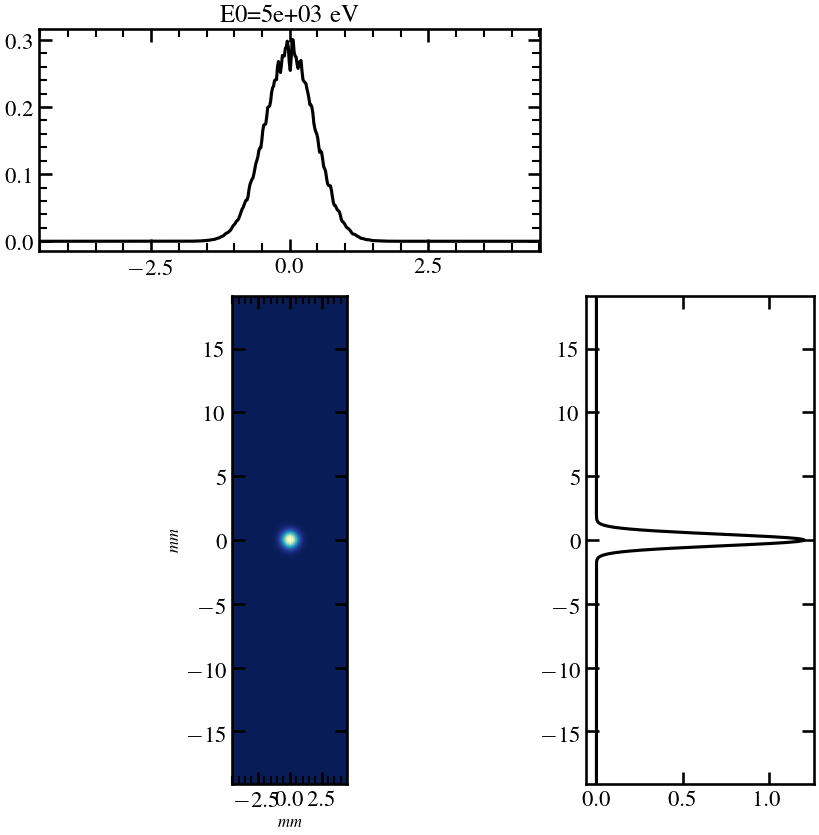

HOM2


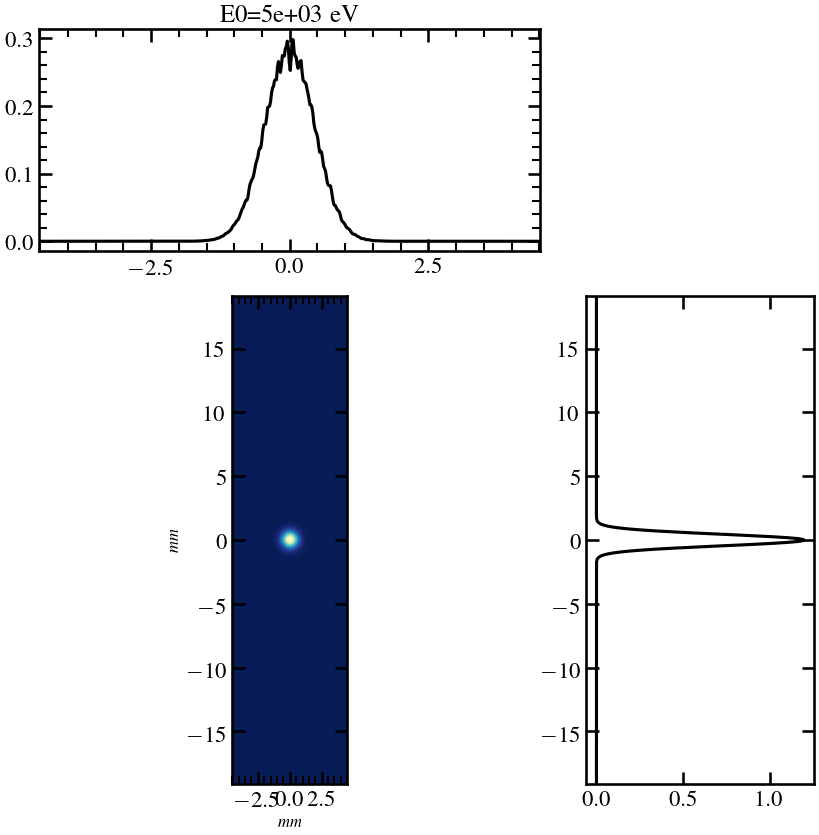

d3


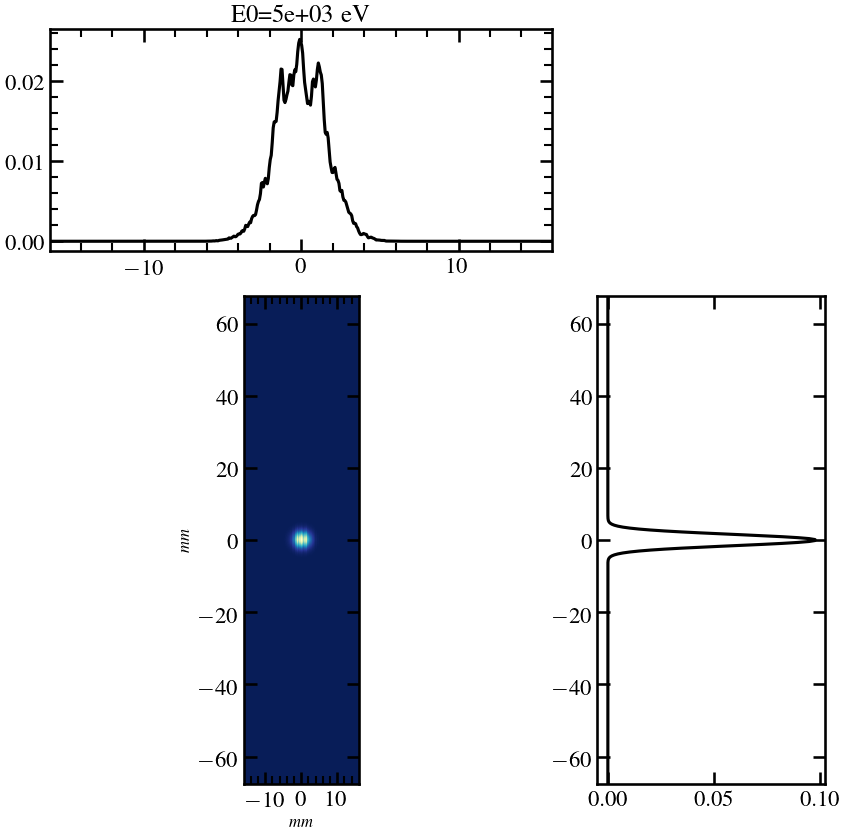

NKB_PSlit


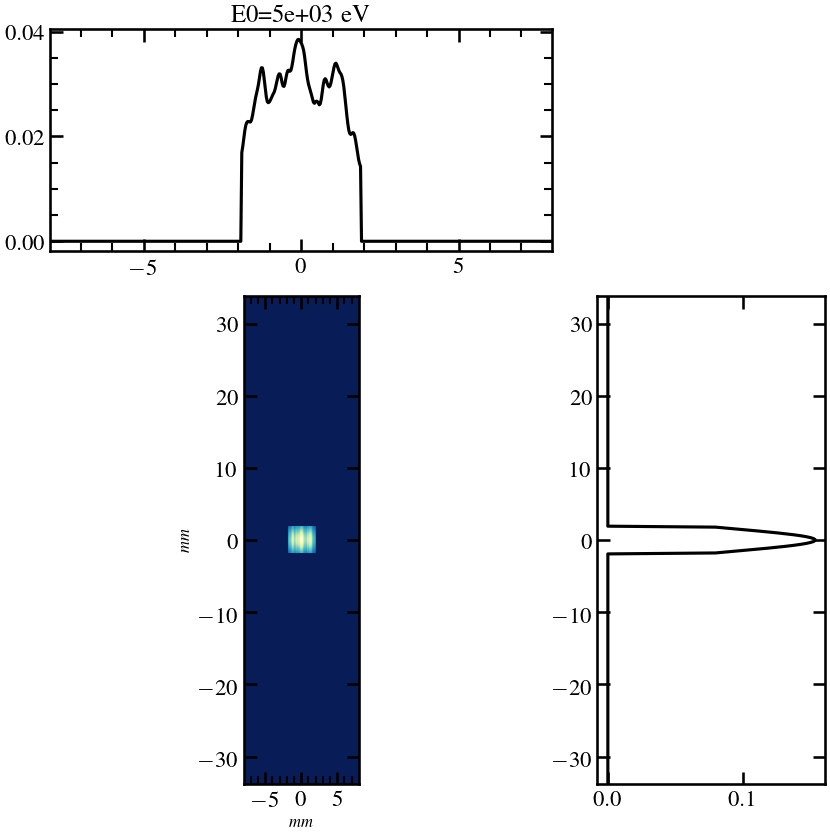

d4


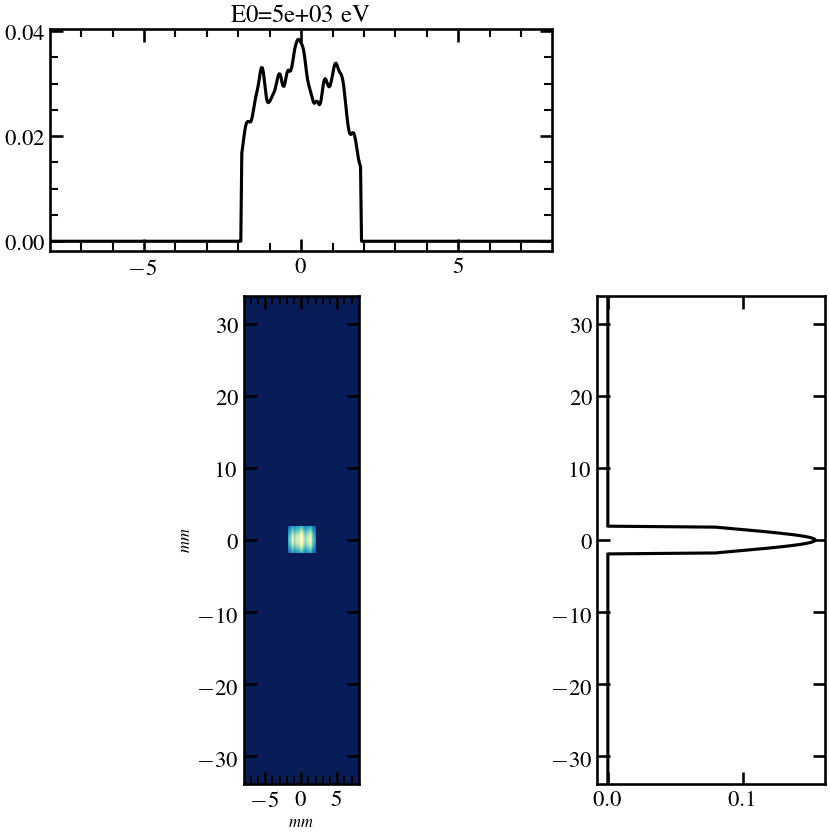

NHE_error


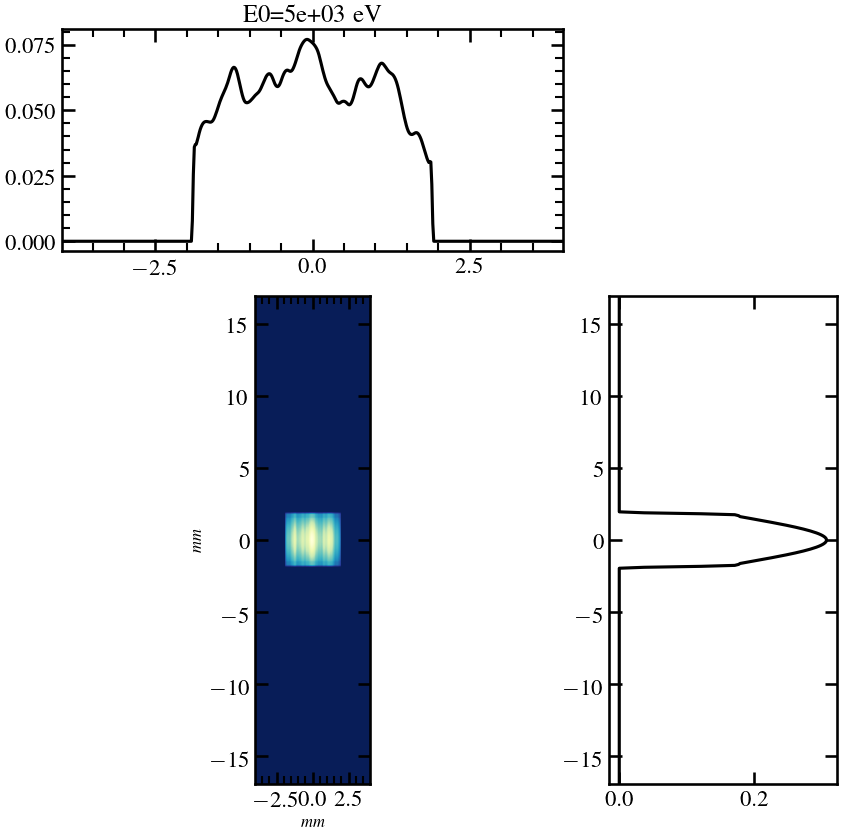

NHE


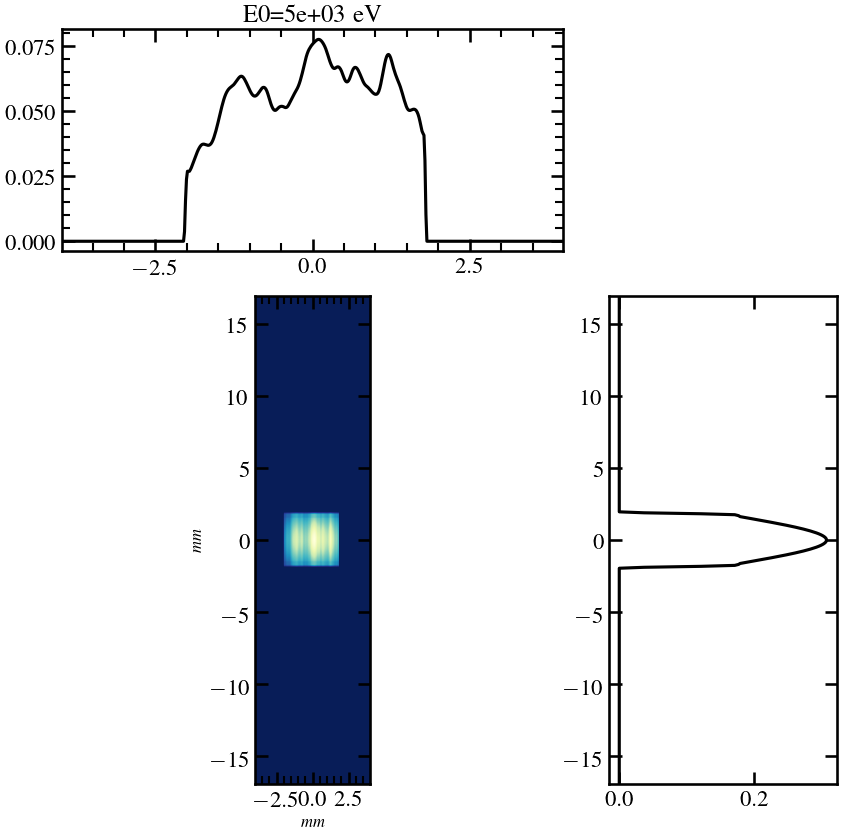

d5


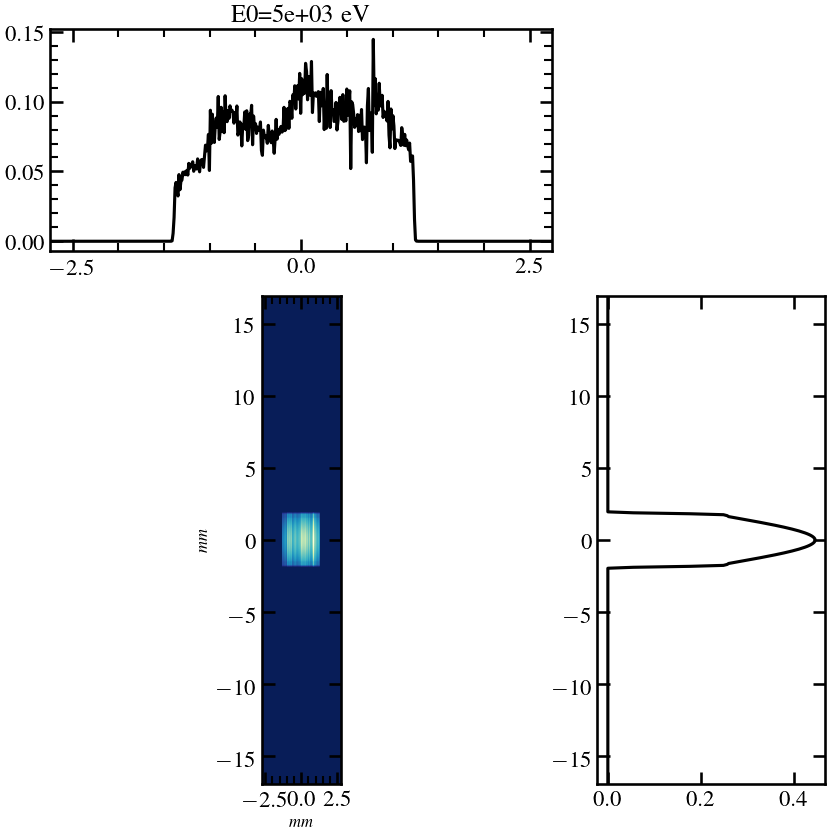

NVE_error


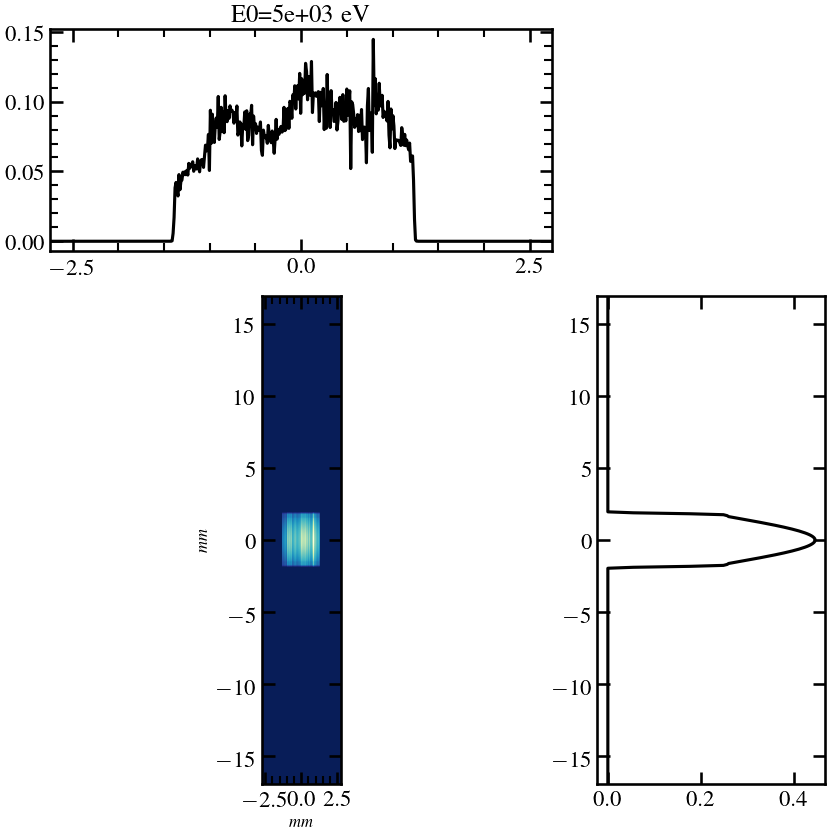

NVE


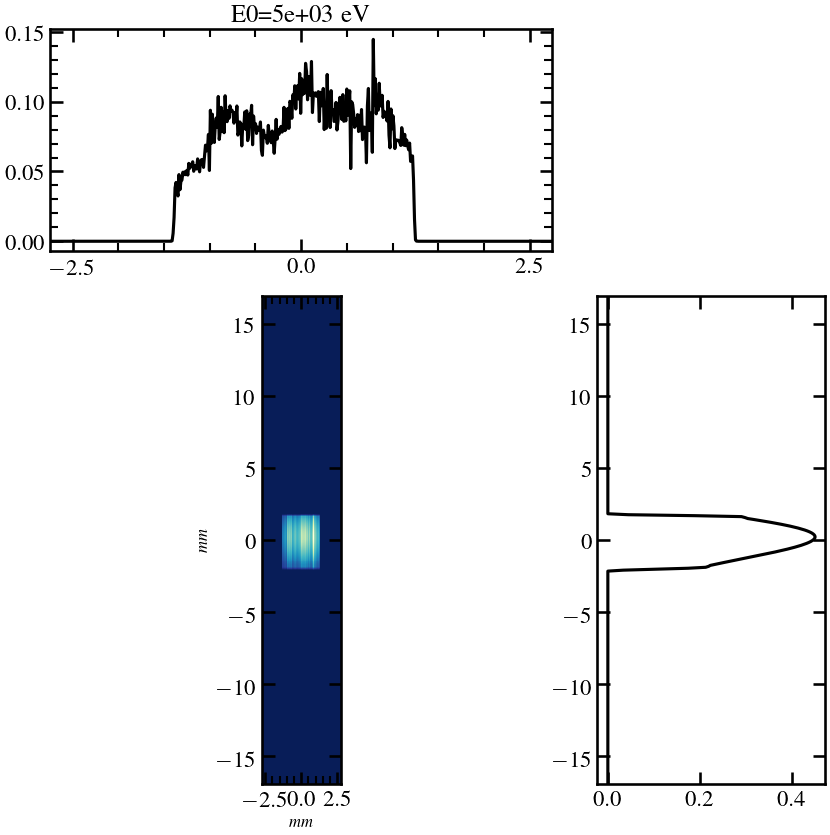

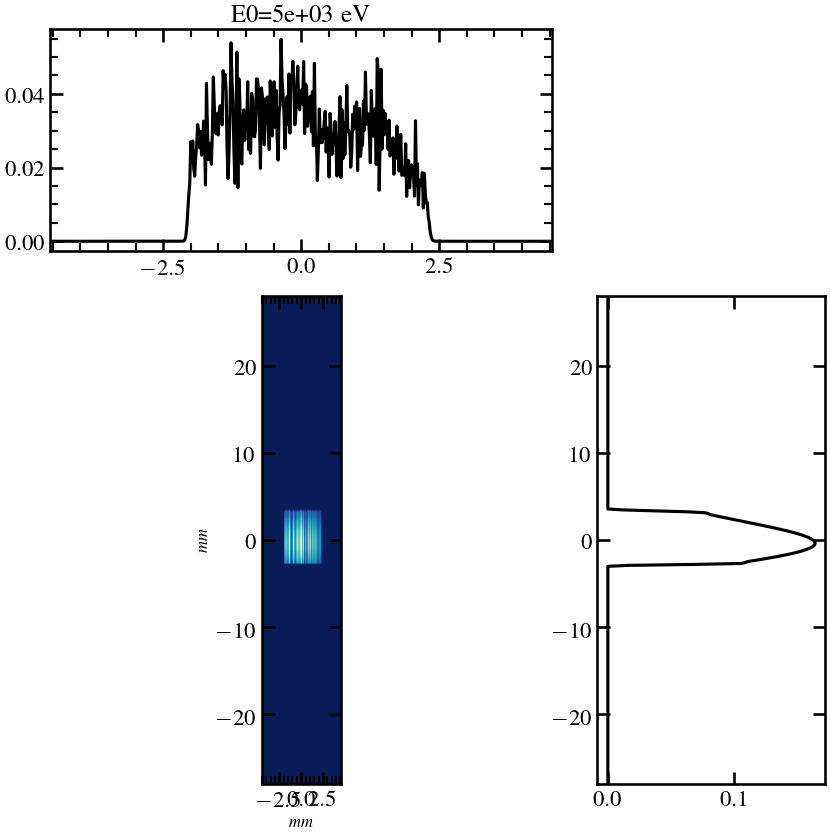

In [19]:
mesh = Mesh(nx = 512, ny = 512, xMin = -300e-06, xMax = 300e-06, yMin= -300e-06, yMax= 300e-06)
src_GM = SA1_Source(ekev = 5.0, q = 0.25, S = 1, mesh = mesh)
spb = setup_spb(parameter_file = "/gpfs/exfel/data/user/guestt/FELpy/felpy/data/params/spb-sfx_nkb_GM_4.98.json", theta_KB = 5e-03, theta_HOM = 5.0e-03)#bl = spb.bl
spb.bl.append(Drift(2.2+3.644), propagation_parameters(1,1,1,1,mode = 'quadratic'))
spb.bl.propagate_sequential(src_GM.wfr)


(512,) (512, 512)
(250,) (400, 250)


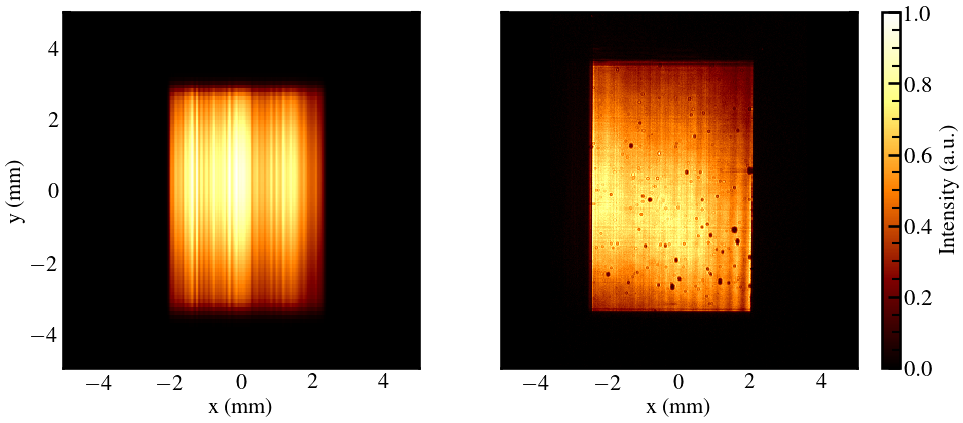

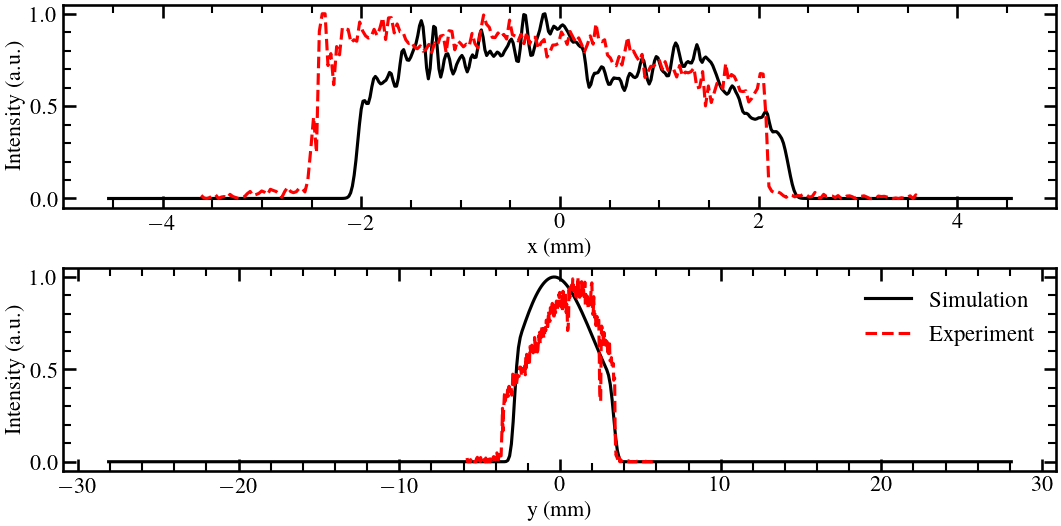

In [32]:
from felpy.utils.daq_utils import load_data, shimadzu_reshape
from extra_data import open_run, RunDirectory, H5File
import numpy as np

proposal = 'p002717'
run_str = '46'

px = py = 28.89e-06



run = open_run(proposal, run_str)
 
source = "SPB_EHD_HPVX2_1/CAM/CAMERA:daqOutput"
image =  np.array(run.get_array(source, 'data.image.pixels'))
image = shimadzu_reshape(image)[:,:,3:103,:]#-darkfield
image = np.delete(image, 24, axis = -1) ## 24th train indicates no data

mesh = Mesh(y = np.linspace(-px*image.shape[0]/2, px*image.shape[0]/2, image.shape[0]),
            x = np.linspace(-py*image.shape[1]/2, py*image.shape[1]/2, image.shape[1])) 


exp = Source(mesh = mesh)
setattr(exp, "ii", image[:,:,12,62])

from felpy.utils.vis_utils import Grids

def kwargs_limit_check(kwargs, ax):
    
    if 'xlim' in kwargs:
        ax.set_xlim(kwargs.get("xlim"))
    if 'ylim' in kwargs:
        ax.set_ylim(kwargs.get("ylim"))
        
def scale_label(scale = 1):
    """ 
    scale label is effectively a smart dictionary for choosing scales in plotting. 
    for now, it is strictly limited to measurements in meters - from micron to m. 
    
    :param scale: length scale of the field to be plotted.
    """    
    if  scale == 1:
        return "m"
    
    elif scale == 1e-02:
        return "cm"
    
    elif scale == 1e-03:
        return "mm"
    
    elif scale == 1e-06:
        return "$\mu m$"
    else:
        raise Warning("Scale not recognised")

def compare_source_wavefronts(sources, global_aspect = 2, fontsize = 16, scale = 1, labels = None, **kwargs):
    """
    compare the two-dimensional profile of a set of sources
    
    :param sources: list of source elements
    :param fontsize: grid fontsize 
    :param labels: list of labels of length = len(sources)
    """
    
    grid = Grids(scale = 2, global_aspect = global_aspect, context = 'talk')
   

    grid.create_grid(n=1,m=len(sources), sharex = False, sharey = True)
    
    grid.add_global_colorbar("Intensity (a.u.)", fontsize = fontsize, cmap = 'afmhot')

    grid.get_axes()[0].set_ylabel("y ({})".format(scale_label(scale)))
    grid.set_fontsize(fontsize)
    
    if labels is not None:
        if len(sources) != len(labels):
            raise Warning("The length the list of labels should be equal to the number of sources provided")
            
    for itr, src in enumerate(sources):
        
        ax = grid.get_axes()[itr]
        ax.set_xlabel("x ({})".format(scale_label(scale)))
        
        if hasattr(src, "wfr"):
            src.__update__()
            ax.imshow(gaussian_filter(src_GM.wfr.get_intensity().sum(-1), sigma = 1.5, mode = 'constant', cval = 0), cmap = 'afmhot', extent = [val*(1/scale) for val in src.mesh.get_extent()])
        elif hasattr(src, "wfr") is False:
            if hasattr(src, "ii"): 
                ax.imshow(src.ii, cmap = 'afmhot', extent = [val*(1/scale) for val in src.mesh.get_extent()])
            else: 
                raise Warning("This source has no plottable properties")
        
        if 'xlim' in kwargs:
            ax.set_xlim((a*(1/scale)) for a in kwargs.get("xlim"))
        if 'ylim' in kwargs:
            ax.set_ylim((a*(1/scale)) for a in kwargs.get("ylim"))

        ax.set_facecolor("black")

    
    return grid

def compare_source_profiles(sources, global_aspect = 2, fontsize = 16, scale = 1, labels = None, **kwargs):
    """
    compare the two-dimensional profile of a set of sources
    
    :param sources: list of source elements
    :param fontsize: grid fontsize 
    :param labels: list of labels of length = len(sources)
    """
    
    grid = Grids(scale = 2, global_aspect = global_aspect, context = 'talk')
    grid.create_grid(n=2,m=1, sharex = False, sharey = True)

    
    grid.get_axes()[0]
    grid.set_fontsize(fontsize)
    
    axes_x, axes_y = grid.get_axes()
    
    if labels is not None:
        if len(sources) != len(labels):
            raise Warning("The length the list of labels should be equal to the number of sources provided")
        
    
    
    for itr, src in enumerate(sources):
        
        if hasattr(src, "wfr"):
            ii = gaussian_filter(src_GM.wfr.get_intensity().sum(-1), sigma = 1.5, mode = 'constant', cval = 0)

        else:
            ii = src.ii

            
        ### note: in this case, axes_x and axes_y refer to the two matplotlib axes elements for which the x- and y-profiles are plotted.
        axes_x.set_xlabel("x ({})".format(scale_label(scale)))
        axes_x.set_ylabel("Intensity (a.u.)")
        print(src.get_axes('x').shape, ii.shape)
        axes_x.plot(src.get_axes('x')*(1/scale), norm(ii[ii.shape[0]//2,:]), label = labels[itr])
        
        axes_y.set_xlabel("y ({})".format(scale_label(scale)))
        axes_y.set_ylabel("Intensity (a.u.)")
        axes_y.plot(src.get_axes('y')*(1/scale), norm(ii[:,ii.shape[1]//2]), label = labels[itr])

    axes_y.legend()
    

    
    return grid

src_GM.__update__()

compare_source_wavefronts([src_GM, exp], scale = 1e-03, global_aspect = 2.5, sharey = True, xlim = (-5e-03, 5e-03), ylim = (-5e-03, 5e-03))
compare_source_profiles([src_GM, exp], scale = 1e-03, global_aspect = 2, labels = ["Simulation", "Experiment"])
